# Sales Forecasting cont. (pt.2)

### Modeling with the primary objective of:
**Forecast Sales:** 
- Predict future sales across various products and timeframes—weekly, monthly, and quarterly. 
- This foresight will enable [Company] to optimize inventory levels, ensuring products are adequately stocked to meet demand without overburdening storage with excess inventory.

### 

---
### <u>Retrieving Data from pt.1

- #### Installing Libraries

In [23]:
# INSTALLATIONS
# !pip install pandas
# !pip install openpyxl
# !pip install numpy
# !pip install xgboost
# !pip install lightgbm
# !pip install category_encoders


- #### Importing Libraries into Project
    - Setting pandas parameters to see the full amount of information from my dataset

In [24]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

- #### Reading file into my project

In [25]:
f_path = r'/content/drive/MyDrive/UCBerkeley/SalesForecasting/data/AmazonSalesReport.csv'
csv_path = r'data\AmazonSalesReport.csv'
xlsx_path = r'data\AmazonSalesReport.xlsx'

if os.path.isfile(csv_path):
    print('Reading File.')
else:
    print("Need to create this file")
    # Load the XLSX file
    # df = pd.read_excel(xlsx_path)
    # -----------------------------------------
    # Save to CSV format
    # df.to_csv(csv_path, index=False)  # Set index=False to not write row indices

df = pd.read_csv(csv_path)

Reading File.


- #### Grabbing a sample of my dataset to reference decisions from part 1 of the project

In [26]:
df.sample(1)

,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
12823,403-0736385-1331568,2022-04-22,Shipped,Amazon,Amazon.in,Expedited,SET331,SET331-KR-NP-XL,Set,XL,B09NQ51CH7,Shipped,1,INR,635.0,BENGALURU,KARNATAKA,560004.0,IN,NaN,False,NaN,NaN


---
### <u>Addressing Duplicates

- #### Removing Duplicates with Order ID the Same
    - False-Positive Transactions

In [27]:
duplicates = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicates)
print(f"Number of rows Before Drop: {df.shape[0]}")
df = df.copy().drop_duplicates()
print(f"Number of rows After Drop: {df.shape[0]}")


Number of duplicate rows: 6
Number of rows Before Drop: 128975
Number of rows After Drop: 128969


---
### <u>Addressing Unnecessary Features

- #### Only Keeping Necessary Columns for Analysis

In [28]:
cols_needed = ['Date', 'Amount']
df = df[cols_needed]
df.columns

Index(['Date', 'Amount'], dtype='object')

---
### <u>Addressing Missing Values

- #### Drop missing values to disclude any potential biases
    - Since 'Amount' is crucial for analysis
    - There is only 1 type of currency which is INR (Indian Rupee) * 0.012 for USD conversion

In [29]:
df.dropna(subset='Amount', inplace=True)

- #### Confirm changes by displaying remaining missing values, if any

In [30]:
df.isnull().sum().sort_values(ascending=False)

Date      0
Amount    0
dtype: int64

---
### <u>Time-Series Cleaning</u>

- #### Change 'Date' column into a datetime object

In [31]:
df['Date'] = pd.to_datetime(df['Date'])

- #### Aggregate sales data to get total daily sales

In [32]:
daily_sales = df.groupby('Date')['Amount'].sum().reset_index()

- #### Set 'Date' as the index

In [33]:
daily_sales.set_index('Date', inplace=True)
daily_sales.head()

,Amount
Date,
2022-03-31,101683.85
2022-04-01,865478.60
2022-04-02,913101.53
2022-04-03,1011763.38
2022-04-04,882059.17


---
### <u>Time-Series Visualizing</u>

- #### Visualizing daily sales over time

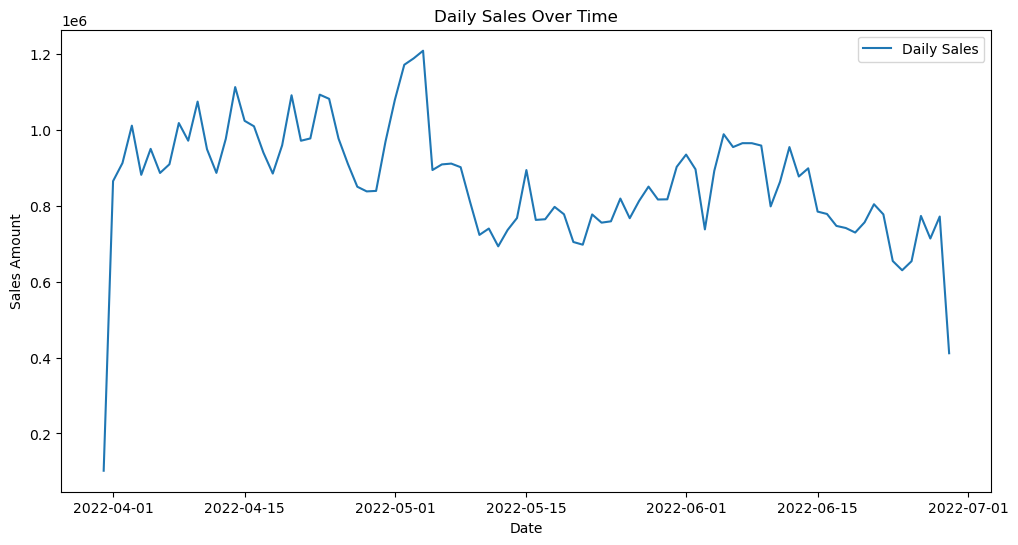

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['Amount'], label='Daily Sales')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.show()

- #### Autocorrelation Understanding

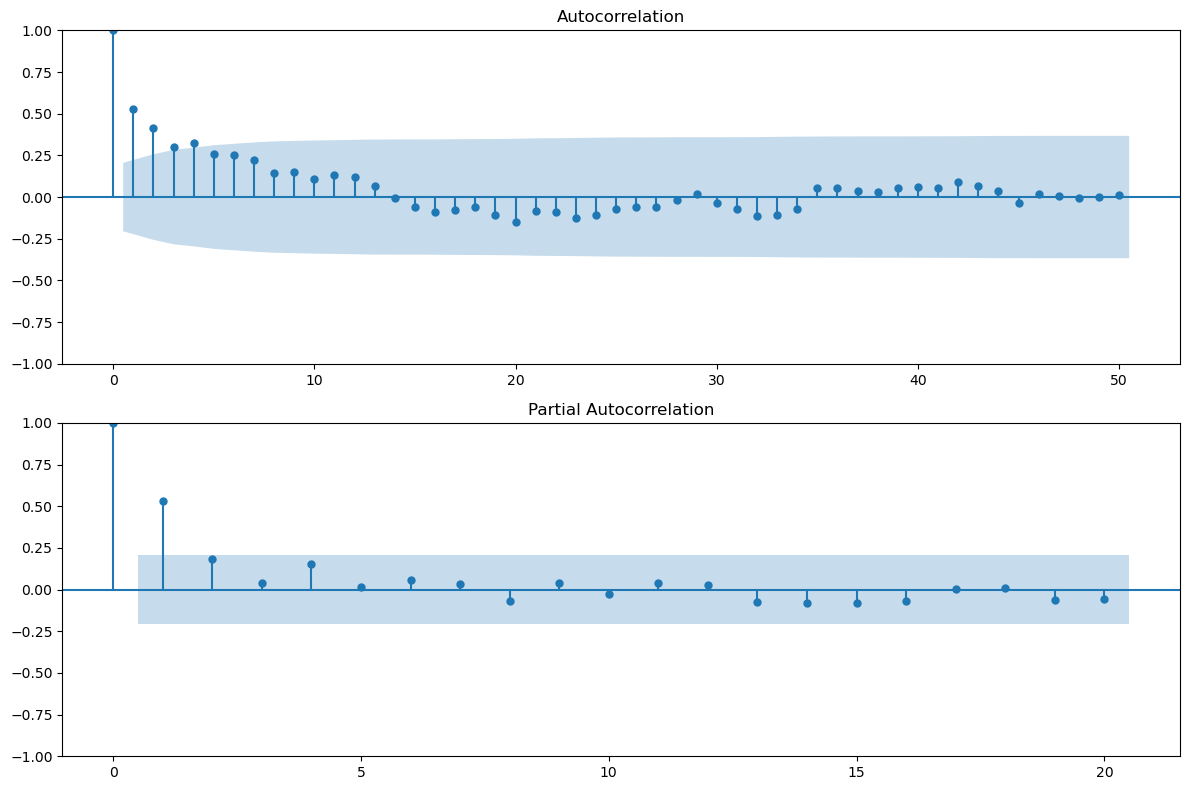

In [35]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(daily_sales['Amount'], lags=50, ax=ax1)

# PACF plot
plot_pacf(daily_sales['Amount'], lags=20, ax=ax2)

plt.tight_layout()
plt.show()

- #### Takeaway from Visualizations

##### ACF Plot: 
- Shows significant autocorrelation at various lags, which could indicate potential seasonality or the need for differencing if the series wasn't already stationary. 
- However, since our series is stationary, this might hint at seasonality.
##### PACF Plot: 
- Demonstrates a sharp cut-off after the first few lags, suggesting that a few AR terms might be significant in an ARIMA model.

**Given these observations, and to account for potential seasonality as suggested by the ACF plot, a SARIMA model might be more appropriate for capturing both the non-seasonal and seasonal aspects of the data.**

---
### <u>Time-Series Preprocessing</u>

- #### Split the data into train and test sets

In [36]:
train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[0:train_size], daily_sales[train_size:len(daily_sales)]


- #### building an ARIMA baseline model
    - specify 'D' to say that the frequency of data points is 1 day apart

In [37]:
arima_model = ARIMA(train, order=(1, 0, 1), freq='D')

C:\Users\CAG\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


- #### Building a SARIMA model to account for both seasonality and non-seasonality
    - (P,D,Q,s) / (e.g., weekly, monthly, quarterly patterns) 
    - Seasonal Autoregressive order (P)
    - Seasonal Differencing order (D)
    - Seasonal Moving Average order (Q)
    - The number of time steps for a single seasonal period (s)
    - (1,1,1,30) because a month is typically 30 days

In [38]:
sarima_model = SARIMAX(train,
                       order=(1, 0, 1),
                       seasonal_order=(1, 1, 1, 7),
                       enforce_stationarity=False,
                       enforce_invertibility=False,
                       freq='D')

C:\Users\CAG\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


---
### <u>Time-Series Modeling</u>

- #### Fit the baseline model

In [39]:
arima_model_fit = arima_model.fit()

- #### Fit the SARIMA model

In [40]:
sarima_model_fit = sarima_model.fit()

---
### <u>ARIMA Evaluation

- #### ARIMA Forecasting Predicted

In [41]:
forecast = arima_model_fit.forecast(steps=len(test))

- #### Calculate RMSE for ARIMA

In [42]:
rmse = sqrt(mean_squared_error(test, forecast))
print(f"Model RMSE: {rmse}")

Model RMSE: 178917.3341857717


- #### ARIMA Predicted vs. Actual

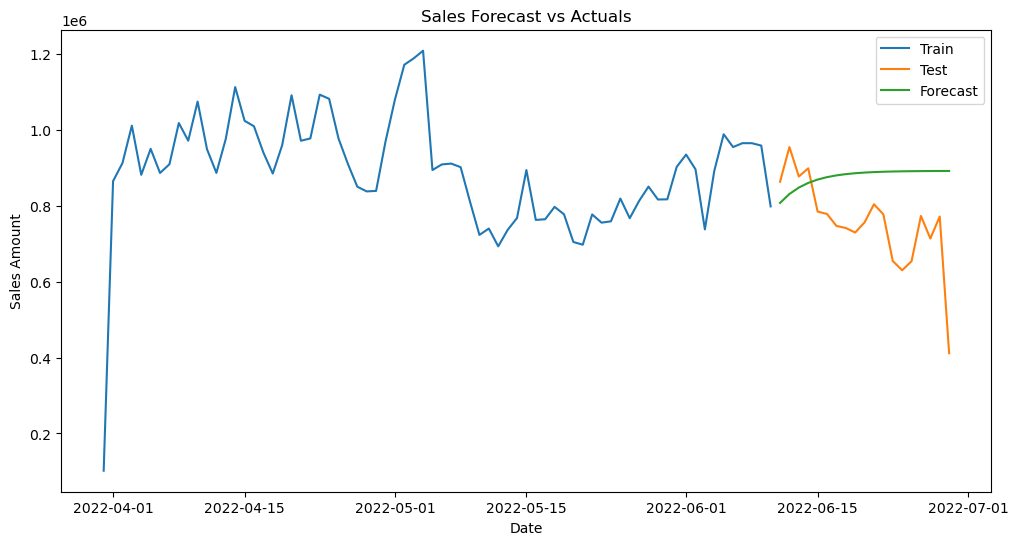

In [43]:
# Plot the forecast against the actual outcomes
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Amount'], label='Train')
plt.plot(test.index, test['Amount'], label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.title('Sales Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.show()

---
### <u>SARIMA Evaluation

- #### SARIMA Forecasting Predicted

In [44]:
sarima_forecast = sarima_model_fit.forecast(steps=len(test))

- #### Calculate RMSE for SARIMA

In [45]:
sarima_rmse = sqrt(mean_squared_error(test, sarima_forecast))
print(f"SARIMA Model RMSE: {sarima_rmse}")

SARIMA Model RMSE: 167712.21109758655


- #### SARIMA Predicted vs. Actual

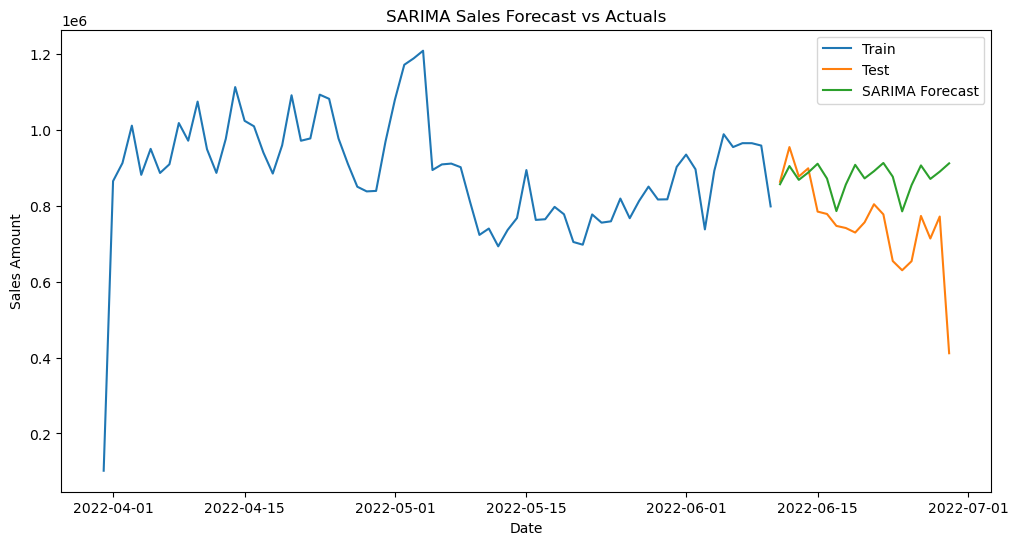

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Amount'], label='Train')
plt.plot(test.index, test['Amount'], label='Test')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.title('SARIMA Sales Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.show()